## Ruler Detection & matching

First download the dataset, embeddings, and yolo model

In [5]:
!wget -O Herbarium_rulers.zip https://cloud.ilabt.imec.be/index.php/s/8yQYcoq2LGLM64b/download
!unzip Herbarium_rulers.zip
!mv "Herbarium_rulers" "dataset"

--2025-10-16 06:48:00--  https://cloud.ilabt.imec.be/index.php/s/8yQYcoq2LGLM64b/download
Resolving cloud.ilabt.imec.be (cloud.ilabt.imec.be)... 193.191.148.202, 2001:6a8:1d80:26::202
Connecting to cloud.ilabt.imec.be (cloud.ilabt.imec.be)|193.191.148.202|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘Herbarium_rulers.zip’

Herbarium_rulers.zi     [<=>                 ] 128.33M  17.2MB/s    in 7.8s    

2025-10-16 06:48:09 (16.5 MB/s) - ‘Herbarium_rulers.zip’ saved [134568731]

Archive:  Herbarium_rulers.zip
   creating: Herbarium_rulers/
 extracting: Herbarium_rulers/clip_image_features.h5  
   creating: Herbarium_rulers/ruler_crops_normalized/
 extracting: Herbarium_rulers/ruler_crops_normalized/1024567574_ruler_block-10-Kew_0.jpg  
 extracting: Herbarium_rulers/ruler_crops_normalized/1024567574_ruler_block-10-Kew_0.json  
 extracting: Herbarium_rulers/ruler_crops_normalized/1024567574_ruler_block-10-Kew_1.jpg  
 ex

### Install dependencies

In [6]:
%pip install open_clip_torch transformers opencv-python annoy h5py ultralytics supervision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 13.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 47.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.2/207.2 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.9 MB/s eta 0:00:00
  Created wheel for annoy: filename=annoy-1.17.3-cp312-cp312-linux_x86_64.whl size=551810 sha256=e28acbbbb81de4c09baf676e71f7145e784b740be29c492e44e68aba94d1f1a8
  Stored in directory: /root/.cache/pip/wheels/db/b9/53/a3b2d1fe1743abadddec6aa541294b24fdbc39d7800bc57311
Successfully built annoy


Install LightGlue

https://github.com/cvg/LightGlue

In [7]:
!git clone https://github.com/cvg/LightGlue
%cd LightGlue
%pip install -e .
%cd ..

Cloning into 'LightGlue'...
remote: Enumerating objects: 411, done.
remote: Total 411 (delta 0), reused 0 (delta 0), pack-reused 411 (from 1)
Receiving objects: 100% (411/411), 13.70 MiB | 31.45 MiB/s, done.
Resolving deltas: 100% (247/247), done.
/content/LightGlue
Obtaining file:///content/LightGlue
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 75.9 MB/s eta 0:00:00
  Building editable for lightglue (pyproject.toml) ... done
  Created wheel for lightglue: filename=lightglue-0.0-0.editable-py3-none-any.whl size=14947 sha256=eafc39c1bc1ba0be2785207c54ca891ca02d980ea9068912018b797b728c5168
  Stored in directory: /tmp/pip-ephem-wheel-cache-z0nnu87j/wheels/cf/9b/1a/81fa7a2b7fcca8ea5e4260afdba28e00ee2

Download sample herbarium sheet from GBIF or other source

Example from: https://www.gbif.org/occurrence/5069313368

In [12]:
!wget -O sample.jpg https://media01.symbiota.org/media/seinet/swnode/DES/DES00101/DES00101668.jpg

--2025-10-16 07:27:00--  https://media01.symbiota.org/media/seinet/swnode/DES/DES00101/DES00101668.jpg
Resolving media01.symbiota.org (media01.symbiota.org)... 104.18.31.188, 104.18.30.188, 2606:4700::6812:1ebc, ...
Connecting to media01.symbiota.org (media01.symbiota.org)|104.18.31.188|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3189644 (3.0M) [image/jpeg]
Saving to: ‘sample.jpg’

sample.jpg          100%[===================>]   3.04M  --.-KB/s    in 0.1s    

2025-10-16 07:27:01 (21.6 MB/s) - ‘sample.jpg’ saved [3189644/3189644]



### Detect rulers with YOLO

Using device: cpu

image 1/1 /content/sample.jpg: 1024x704 1 ruler, 985.5ms
Speed: 16.8ms preprocess, 985.5ms inference, 13.9ms postprocess per image at shape (1, 3, 1024, 704)


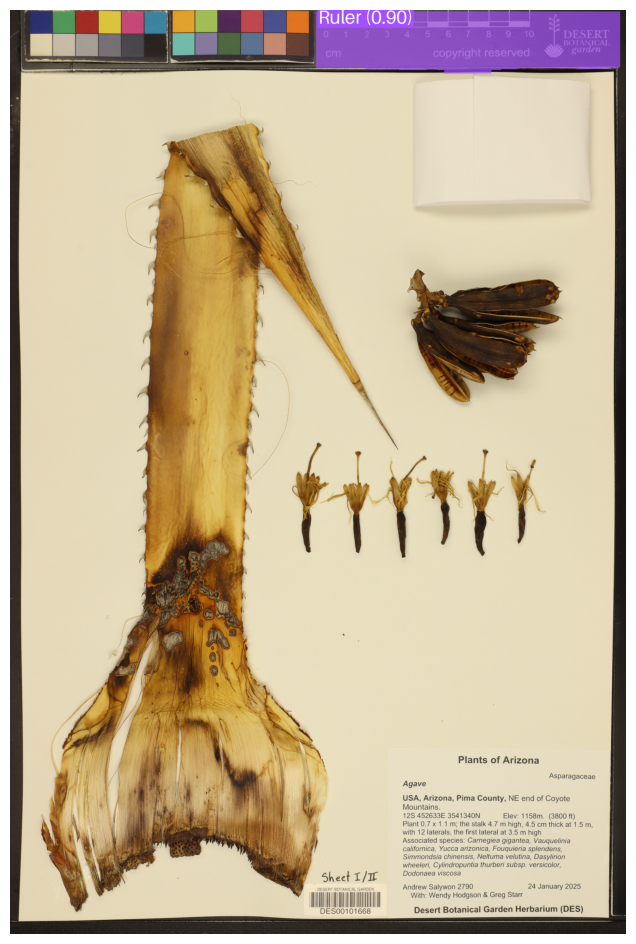

In [26]:
import os
import json
import re
import copy
from pathlib import Path

import numpy as np
from matplotlib import pyplot as plt
import cv2
from annoy import AnnoyIndex
from PIL import Image
from tqdm.auto import tqdm
import h5py
import supervision as sv

import torch
import open_clip
from lightglue import LightGlue, SuperPoint, DISK
from lightglue.utils import load_image, rbd
from lightglue import viz2d
from ultralytics import YOLO


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
np.set_printoptions(suppress=True)
torch.set_grad_enabled(False)

yolo_model_path = "dataset/yolo_rulers.pt"
img_path = "sample.jpg"

# Load the YOLO model
model = YOLO(yolo_model_path)

# Perform inference
results = model(img_path, imgsz=1024)

# Extract detections
detections = sv.Detections.from_ultralytics(results[0])

# Load the image
image = cv2.imread(img_path)

# Create a mask annotator
mask_annotator = sv.MaskAnnotator(opacity=0.7, color_lookup=sv.ColorLookup.INDEX)

label_annotator = sv.RichLabelAnnotator(
        text_color=sv.Color.from_hex("#FFFFFF"),
        color_lookup=sv.ColorLookup.INDEX,
        font_size=80,
        text_padding=3,
        smart_position=True,
)


# Create labels for the detections
labels = [
    f"Ruler ({conf:.2f})"
    for conf in detections.confidence
]

# Annotate the image with detections and labels
# Draw polygons
annotated_image = mask_annotator.annotate(
    scene=image.copy(), detections=detections
)

# Draw texts (labels) at polygon centroids
annotated_image = label_annotator.annotate(
    scene=annotated_image, detections=detections, labels=labels
)

# Display the annotated image
sv.plot_image(annotated_image)

Normalize (ensure longest side is horizontal) and save the detected ruler crop to a file

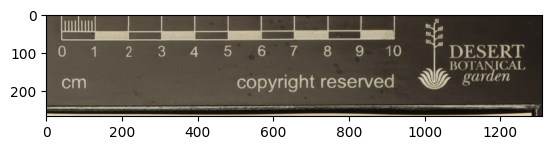

True

In [31]:
ruler_mask = detections[0].mask.squeeze()
rect = cv2.boundingRect(cv2.findNonZero(ruler_mask.astype(np.uint8)))
# Adjust the polygon points
x, y, w, h = rect

ruler_crop = image[y:y+h,x:x+w]
ruler_h, ruler_w = ruler_crop.shape[:2]
if ruler_h > ruler_w:
  ruler_crop = cv2.rotate(ruler_crop, cv2.ROTATE_90_CLOCKWISE)

plt.imshow(cv2.cvtColor(ruler_crop, cv2.COLOR_BGR2RGB))
plt.show()

cv2.imwrite("ruler_crop.jpg", ruler_crop)

### Now, match the ruler to our dataset

First, we need to load our CLIP embeddings from the ground truth dataset

In [32]:
data_dir = "dataset"
h5_path = os.path.join(data_dir, "clip_image_features.h5")

print(f"Loading embeddings from {h5_path}")
with h5py.File(h5_path, 'r') as h5:
    embeddings = np.array(h5['embeddings'], dtype=np.float32)
    filenames = np.array([f.decode('utf-8') for f in h5['filenames']])

    print('Embeddings:', embeddings.shape)
    print('Filenames:', filenames.shape)


Loading embeddings from dataset/clip_image_features.h5
Embeddings: (492, 1024)
Filenames: (492,)


Next, we make an AnnoyIndex for fast matching

In [33]:
annoy_index_path = "clip_annoy_index.ann"
embedding_dim = embeddings.shape[-1]

if not os.path.exists(annoy_index_path):
    print("Making new Annoy Index...")
    annoy_index = AnnoyIndex(embedding_dim, 'dot')
    for idx, embedding in enumerate(embeddings):
        annoy_index.add_item(idx, embedding)

    annoy_index.build(10) # 10 trees
    annoy_index.save(annoy_index_path)
else:
    annoy_index = AnnoyIndex(embedding_dim, 'dot')
    annoy_index.load(annoy_index_path) # super fast, will just mmap the file
    print(f"Loading Annoy Index from {annoy_index_path}")

Making new Annoy Index...


Next, we calculate the CLIP embedding for our detected ruler.

Loading the CLIP model can take some time...

In [34]:
clip_model_name = "CLIP-ViT-H-14-laion2B-s32B-b79K"
clip_model, _, _ = open_clip.create_model_and_transforms(
    "ViT-H-14",
    pretrained="laion2B-s32B-b79K",
)

clip_model.eval().to(device)

The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


open_clip_model.safetensors:   0%|          | 0.00/3.94G [00:00<?, ?B/s]

Downloading: "https://github.com/cvg/LightGlue/releases/download/v0.1_arxiv/superpoint_v1.pth" to /root/.cache/torch/hub/checkpoints/superpoint_v1.pth


100%|██████████| 4.96M/4.96M [00:00<00:00, 99.9MB/s]


Downloading: "https://github.com/cvg/LightGlue/releases/download/v0.1_arxiv/superpoint_lightglue.pth" to /root/.cache/torch/hub/checkpoints/superpoint_lightglue_v0-1_arxiv.pth


100%|██████████| 45.3M/45.3M [00:00<00:00, 279MB/s]


In [45]:
from torchvision import transforms
import torchvision.transforms.functional as F

COLOR_PALETTE = [
    (180, 119,  31),  # Blue
    ( 14, 127, 255),  # Orange
    ( 44, 160,  44),  # Green
    (189, 103, 148),  # Purple
    ( 75,  86, 140),  # Brown
    (194, 119, 227),  # Pink
    (127, 127, 127),  # Gray
    ( 34, 189, 188),  # Olive
    (207, 190,  23)   # Cyan
]

MEAN = np.array([0.48145466, 0.4578275, 0.40821073])
STD = np.array([0.26862954, 0.26130258, 0.27577711])

# see: https://discuss.pytorch.org/t/how-to-resize-and-pad-in-a-torchvision-transforms-compose/71850/5
class SquarePad:
    def __call__(self, image):
        if isinstance(image, np.ndarray):
            image = Image.fromarray(image)

        h,w = image.size

        max_wh = np.max([w, h])
        hp = int((max_wh - w) / 2)
        vp = int((max_wh - h) / 2)
        padding = (hp, vp, hp, vp)

        return F.pad(image, padding, 0, 'constant')

# Define square padding preprocessing function for CLIP
custom_preprocess = transforms.Compose([
    SquarePad(),
    transforms.Resize(size=(224,224), interpolation=transforms.InterpolationMode.BICUBIC, max_size=None, antialias=True),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD),
])


def get_clip_embedding(img, clip_model, preprocess_func, device="cuda"):

    with torch.inference_mode():
        img = preprocess_func(img).unsqueeze(0).to(device)
        embedding = clip_model.encode_image(img)
        embedding /= embedding.norm(dim=-1, keepdim=True)
        embedding = embedding[0]


    return embedding.cpu().numpy()


def show(img):
    return plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

def visualize_ruler_crop(img, ruler_data, kind="normalized", tick_size=20, polygon_size=15,tick_color=None, opacity=0.7):
    out = img.copy()

    if kind == "original":
        points_key = "orig_points"
    elif kind == "crop":
        points_key = "crop_points"
    else:
        points_key = "normalized_points"

    # Show the ruler polygon if not normalized already
    if kind != "normalized":
        ruler_color = (20, 20, 255)
        ruler_polygon = ruler_data.get(points_key, [])
        if len(ruler_polygon):
            pts = np.array(ruler_polygon, dtype=np.int32).reshape(-1, 1, 2)

            if polygon_size > 0:
                cv2.polylines(out, [pts], True, color=ruler_color, thickness=polygon_size)


    tick_labels = ruler_data.get("tick_labels", [])
    # Draw tick points shape (N,2)
    for i, tick_label in enumerate(tick_labels):
        tick_pts = np.array(tick_label[points_key], dtype=np.int32)
        if tick_color is None:
            color = COLOR_PALETTE[i]
        else:
            color = tick_color
        for pt in tick_pts:
            cv2.circle(out, pt, tick_size, color, -1)
    return out

def extract_match_keypoints(img_path0, img_path1, extractor_model, matcher_model):
    image0 = load_image(img_path0)
    image1 = load_image(img_path1)

    feats0 = extractor_model.extract(image0.to(device))
    feats1 = extractor_model.extract(image1.to(device))
    matches01 = matcher_model({"image0": feats0, "image1": feats1})
    feats0, feats1, matches01 = [
        rbd(x) for x in [feats0, feats1, matches01]
    ]  # remove batch dimension

    kpts0, kpts1, matches, match_scores = feats0["keypoints"], feats1["keypoints"], matches01["matches"], matches01["scores"]
    m_kpts0, m_kpts1 = kpts0[matches[..., 0]], kpts1[matches[..., 1]]

    kpts0 = kpts0.cpu().numpy()
    kpts1 = kpts1.cpu().numpy()
    matches = matches.cpu().numpy()
    match_scores = match_scores.cpu().numpy()

    return kpts0, kpts1, matches, match_scores


def get_scaled_size(img_shape, base_size=10, ref_diag=2202.9): # ref_diag for 1920x1080
    """
    Calculates scaled size based on image diagonal.

    Args:
        img_shape (tuple): Shape of the image (height, width, ...).
        base_size (int): The desired size at the reference resolution.
        ref_diag (float): The diagonal of the reference resolution (e.g., sqrt(1920**2 + 1080**2)).

    Returns:
        int: The scaled size, rounded and at least 1.
    """
    H, W = img_shape[:2]
    img_diag = np.sqrt(W**2 + H**2)

    # Avoid division by zero if ref_diag is somehow 0
    if ref_diag <= 0:
        ref_diag = 1.0

    scale_factor = img_diag / ref_diag
    scaled_size = base_size * scale_factor

    # Ensure size is at least 1 and is an integer
    return max(1, int(round(scaled_size)))

def read_resize_img(path, img_shape=(256,700)):
    img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)

    # resize with padding
    h, w = img.shape[:2]
    target_h, target_w = img_shape

    # Compute scale and new size
    scale = min(target_w / w, target_h / h)
    new_w, new_h = int(w * scale), int(h * scale)

    # Resize image
    resized_img = cv2.resize(img, (new_w, new_h))

    # Compute padding values
    pad_top = (target_h - new_h) // 2
    pad_bottom = target_h - new_h - pad_top
    pad_left = (target_w - new_w) // 2
    pad_right = target_w - new_w - pad_left

    # Apply padding
    padded_img = cv2.copyMakeBorder(
        resized_img,
        pad_top, pad_bottom, pad_left, pad_right,
        borderType=cv2.BORDER_CONSTANT,
        value=[0, 0, 0]  # black padding
    )
    return padded_img

def calculate_pixel_distance(points: np.ndarray, tick_label: str):
    """
    Calculate the pixel distance between points and the standard error

    Args:
        points (np.ndarray): The points to calculate the pixel distance between
        tick_label (str): The tick label to parse the measurement from

    Returns:
        float: The average pixel distance
        float: The standard error of the pixel distance
    """

    differences = np.diff(points, axis=0) # axis=0 calculates difference along rows


    # axis=1 calculates norm across columns for each row
    sequential_distances = np.linalg.norm(differences, axis=1)
    avg_dist = np.mean(sequential_distances)
    std_dist = np.std(sequential_distances)

    # Parse the tick label
    # They look like: ticks_1cm - ticks_1inch, ticks_5cm, etc.
    tick_label = tick_label.replace("_partial","").replace("_curved","").replace("_inset","")
    pattern = re.compile(r"^ticks_(\d*\.\d+|\d+)(cm|mm|inch)$")
    match = pattern.fullmatch(tick_label.strip())
    if match:
        measure = float(match.group(1))
        unit = match.group(2)
    else:
        raise ValueError(f"Unable to parse tick label: {tick_label}. Ensure it's of the format: ticks_{{x}}cm/mm/inch, where x is a float")

    if "cm" in unit:
        pass
    elif "inch" in unit:
        measure *= 2.54
    elif "mm" in unit:
        measure /= 10
    else:
        raise ValueError(f"Unknown parsed unit: {unit} - tick label: {tick_label}")

    avg_dist /= measure
    std_dist /= measure

    return avg_dist, std_dist

### Visualize the top 3 most similar CLIP matches

Best matches:
1 2610098598_ruler_block-10-Rancho_0 - Sim: 0.767
2 BM000500117_Dillen_ruler_block-10-NHM_0 - Sim: 0.749
3 1929325030_ruler_block-10-NYBG_0 - Sim: 0.747


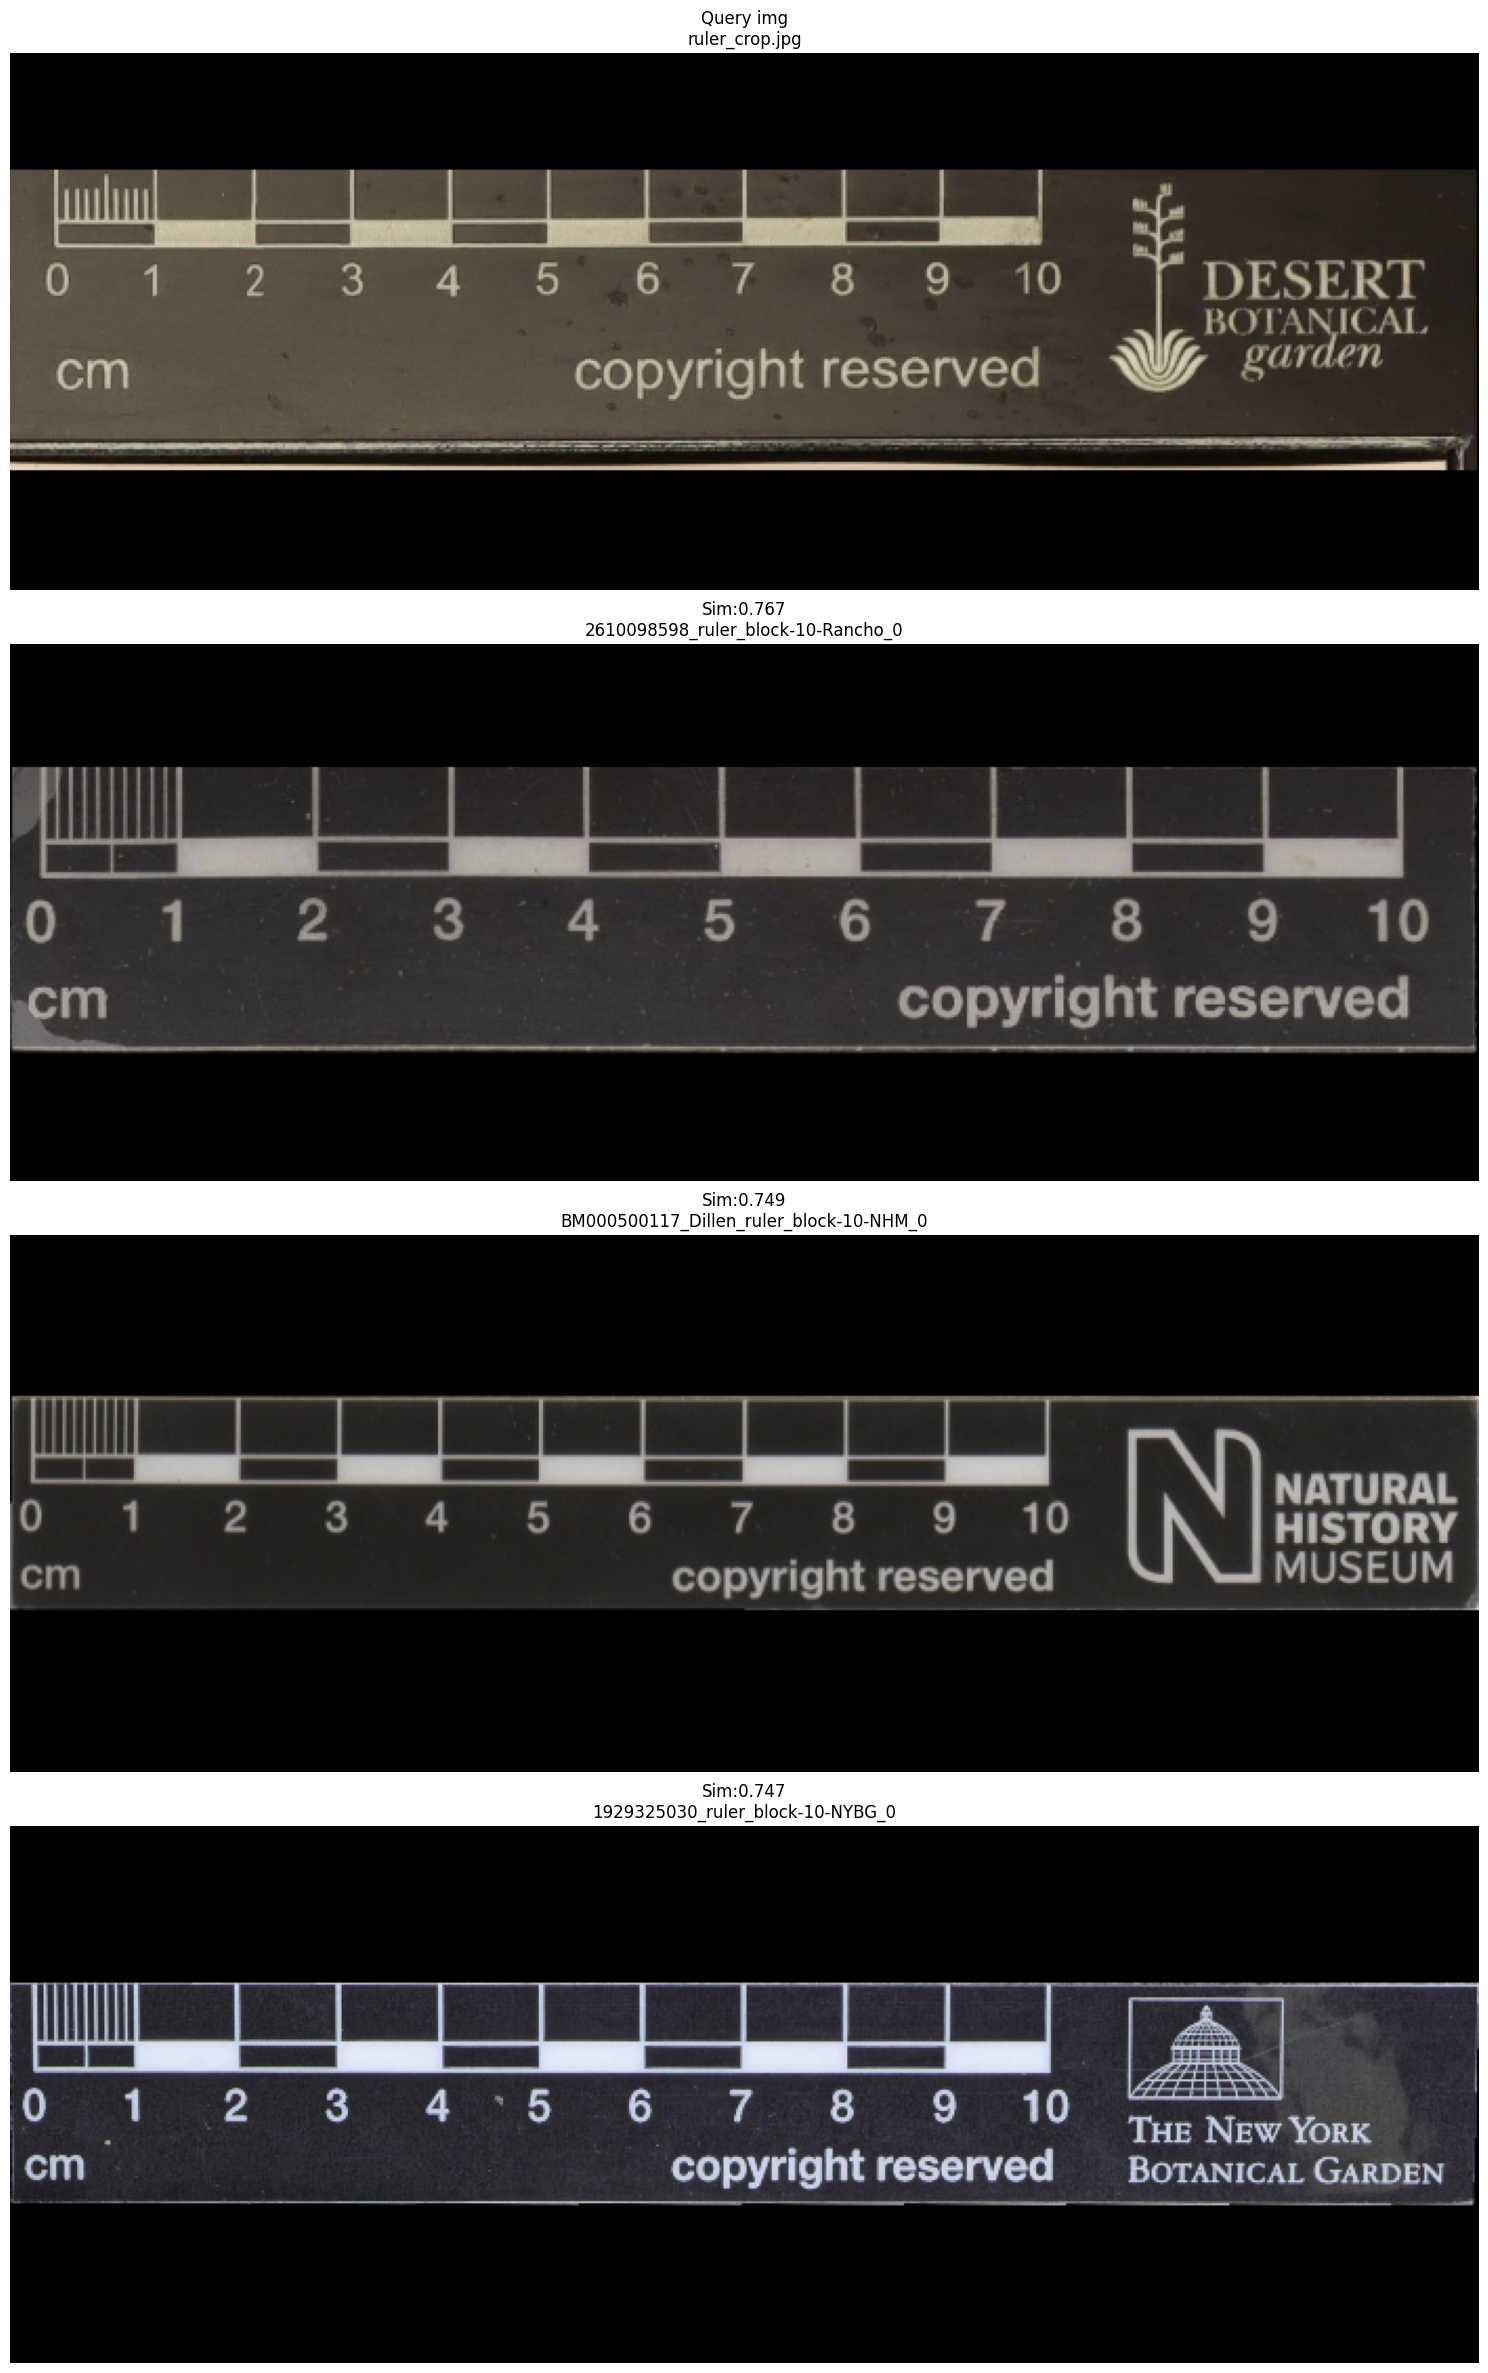

In [46]:
# Params used for the eval in the paper
MIN_MATCHES = 10 # minimum number of LightGlue matches to be considered a positive match
CLIP_TOP_K_MATCHES = 3 # Number of most similar rulers to look at
LIGHTGLUE_TOP_K_MATCHES = 100 # Max amount of keypoint matches to use for the homography
MIN_MATCH_SCORE = 0.5 #  Minimum score of each keypoint match
RANSAC_ITERS = 100000 # Amount of iterations for Ransac during the homography estimation
SCORE_METHOD = "mean" # If the match score is the mean or sum of the best matches

# This is much more than double the max of our ground truth dataset
# Used to remove "impossible" outliers
MAX_CF_VALUE = 2000
MIN_CF_VALUE = 1

query_img_path = "ruler_crop.jpg"
ruler_crop = cv2.cvtColor(cv2.imread(query_img_path), cv2.COLOR_BGR2RGB)
img_dir = "dataset/ruler_crops_normalized"


query_embedding = get_clip_embedding(ruler_crop, clip_model=clip_model, preprocess_func=custom_preprocess,device=device)

best_matches, best_sims = annoy_index.get_nns_by_vector(
            query_embedding, CLIP_TOP_K_MATCHES, include_distances=True
)

best_matches_paths = []
for i in range(len(best_matches)):
  idx = best_matches[i]
  sim = best_sims[i]

  match_fname = filenames[idx]
  title = "".join(match_fname.split("_", 1)[1:]).replace(".jpg", "")

  img_path = os.path.join(img_dir, match_fname)
  best_matches_paths.append(img_path)


plt.figure(figsize=(20, 30))
plt.subplot(CLIP_TOP_K_MATCHES + 1, 1, 1)
plt.imshow(read_resize_img(query_img_path))
plt.axis("off")
plt.title(f"Query img\n{query_img_path}")
print("Best matches:")
for i in range(len(best_matches)):
    sim = best_sims[i]
    img_path = best_matches_paths[i]
    title = os.path.basename(img_path).replace(".jpg", "")
    print(f"{i + 1} {title} - Sim: {sim:.3f}")
    plt.subplot(CLIP_TOP_K_MATCHES + 1, 1, i + 2)
    plt.imshow(read_resize_img(img_path))
    plt.axis("off")
    plt.title(f"Sim:{sim:.3f}\n{title}", fontsize=12)

plt.subplots_adjust(hspace=0.1)
plt.show()

### Match keypoints using LightGlue

For each matched ruler, we show it's ground truth ticks and also the mapped ticks onto the new ruler in red.

We also check the matches with our query image rotated, because we do not know a priori if the detected ruler is correctly oriented

In [47]:
# Init LightGlue models
extractor_model = (
        SuperPoint(max_num_keypoints=None).eval().to(device)
    )
matcher_model = (
    LightGlue(
        features="superpoint",
        depth_confidence=-1,
        width_confidence=-1,
        filter_threshold=MIN_MATCH_SCORE,
    )
    .eval()
    .to(device)
)

query_img_path_rot = os.path.join("ruler_crop_rot.jpg")
if not os.path.exists(query_img_path_rot):
    temp_img = cv2.imread(query_img_path)
    temp_img = cv2.rotate(temp_img, cv2.ROTATE_180)
    cv2.imwrite(query_img_path_rot, temp_img)

output_dir = "outputs"
os.makedirs(output_dir, exist_ok=True)


Total matches standard: 212 - rotated: 0
GT img shape: (224, 1143, 3) - Size:5
Pred img shape: (268, 1311, 3) - Size:6
Ground truth image avg pixel distance: 105.6207 - std: 0.8768
Transformed prediction image avg pixel distance: 87.8473 - std: 0.7955


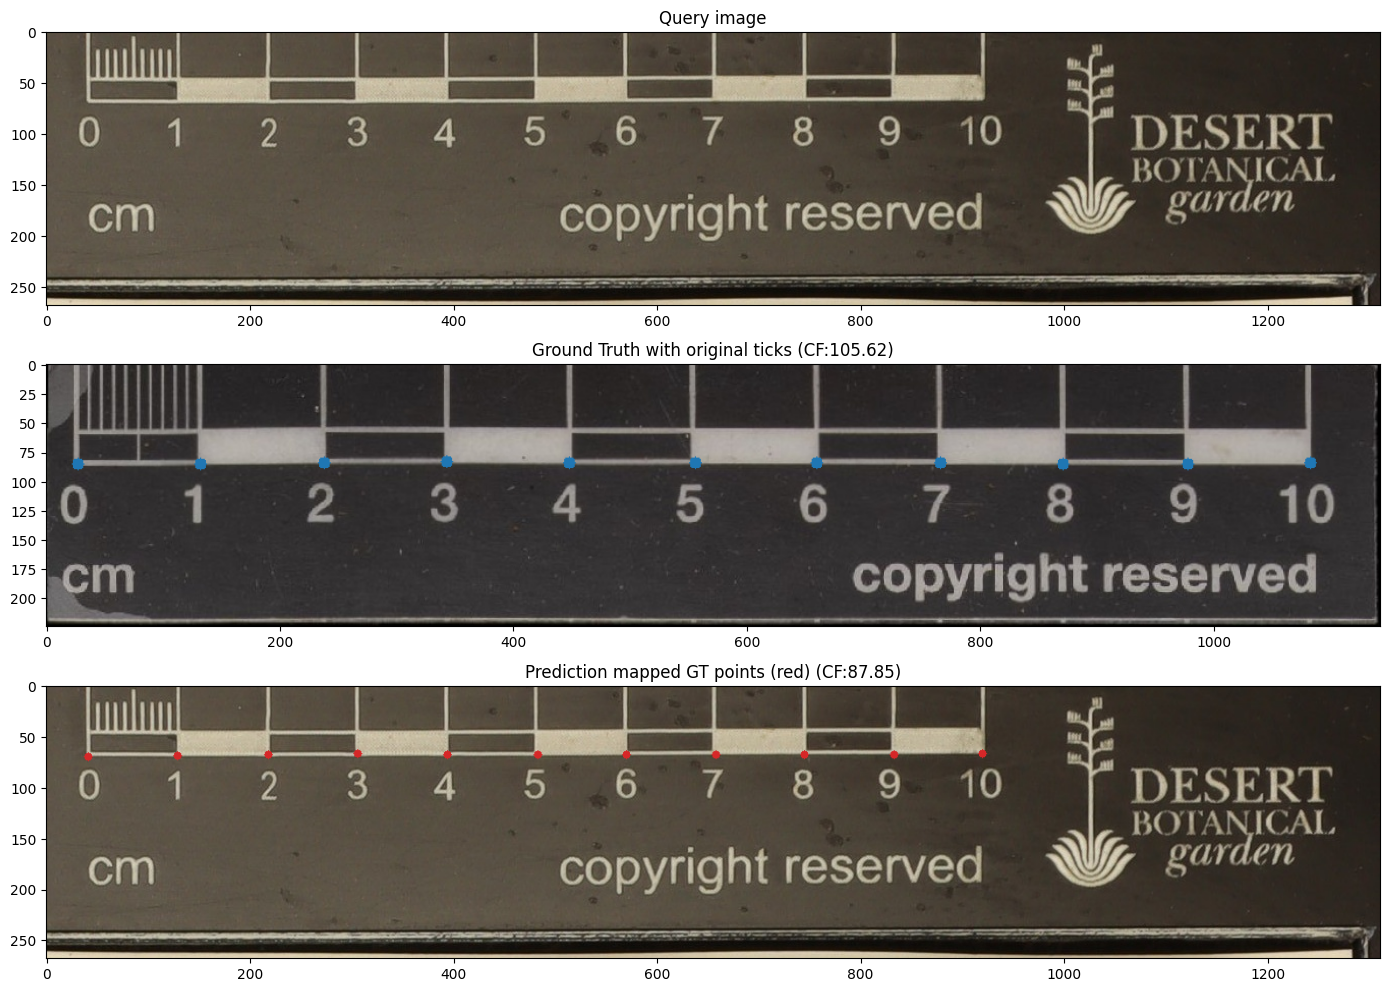

Total matches standard: 206 - rotated: 13
GT img shape: (131, 892, 3) - Size:4
Pred img shape: (268, 1311, 3) - Size:6
Ground truth image avg pixel distance: 61.6010 - std: 0.5784
Transformed prediction image avg pixel distance: 88.1487 - std: 1.6575


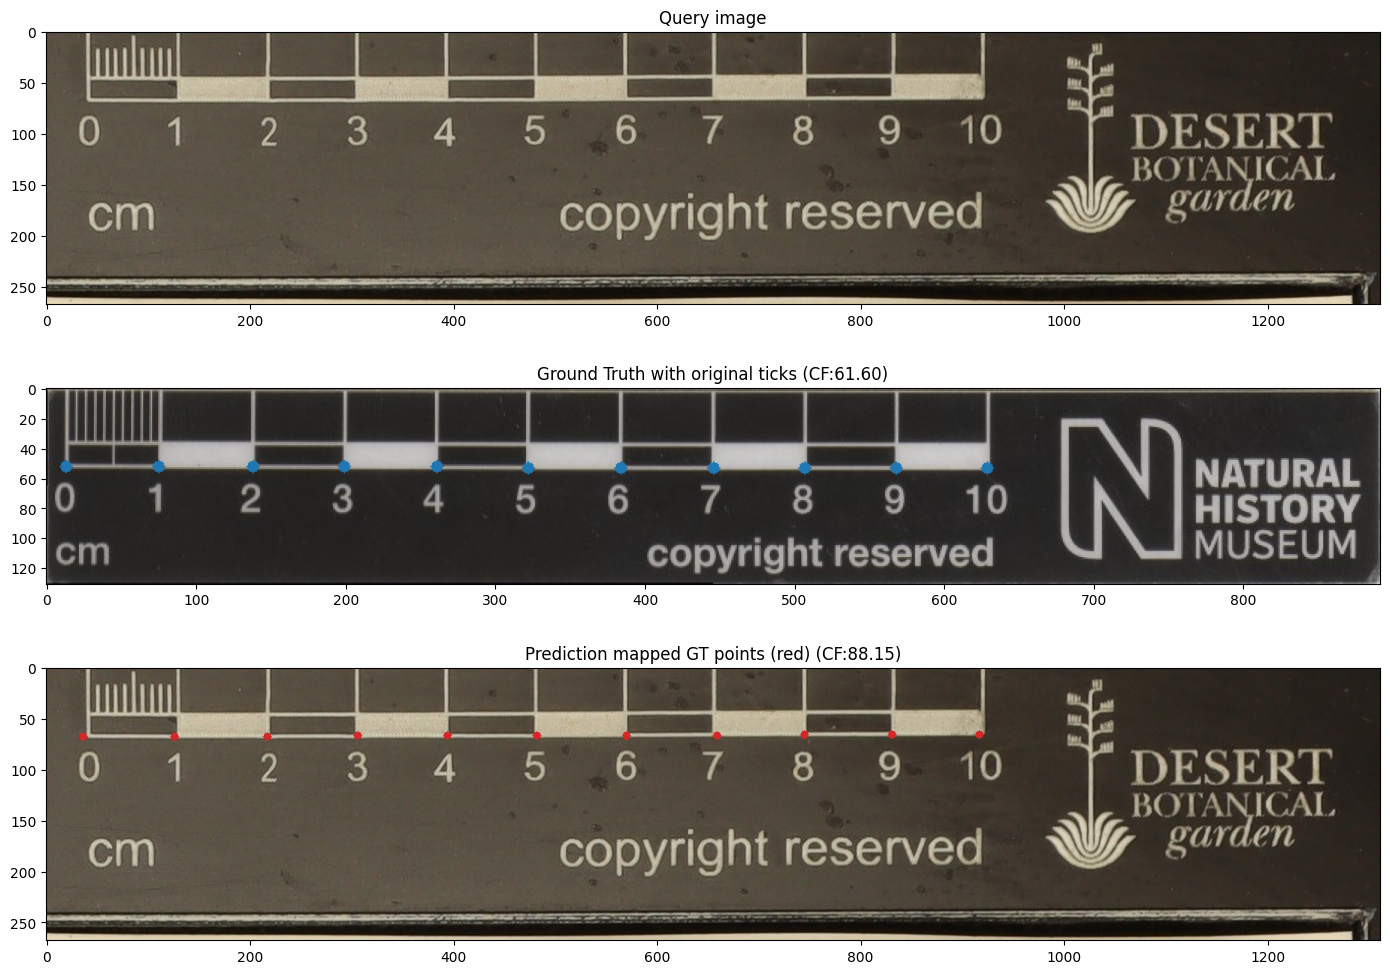

Total matches standard: 204 - rotated: 0
GT img shape: (269, 1774, 3) - Size:8
Pred img shape: (268, 1311, 3) - Size:6
Ground truth image avg pixel distance: 122.2446 - std: 1.3119
Transformed prediction image avg pixel distance: 87.8346 - std: 0.9731


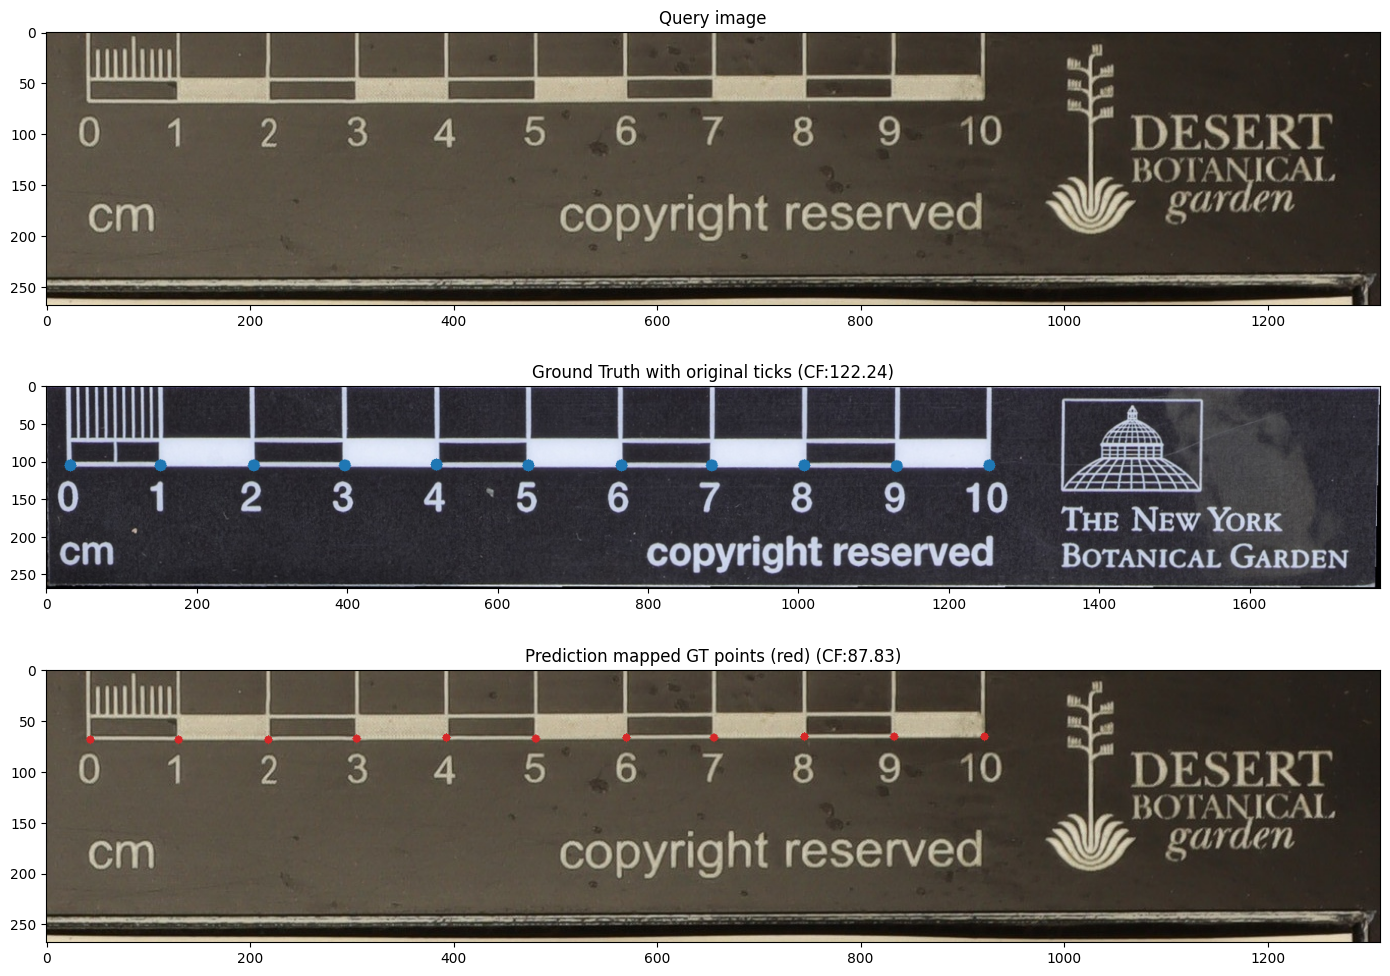

In [50]:
img_path1 = query_img_path
img_path1_rot = query_img_path_rot

for idx, img_path0 in enumerate(best_matches_paths):


  kpts0, kpts1, matches, match_scores = extract_match_keypoints(
      img_path0, img_path1, extractor_model, matcher_model
  )
  num_matches = len(matches)

  # Rotated image
  kpts0_rot, kpts1_rot, matches_rot, match_scores_rot = (
      extract_match_keypoints(
          img_path0, img_path1_rot, extractor_model, matcher_model
      )
  )
  num_matches_rot = len(matches_rot)
  print(
      f"Total matches standard: {len(matches)} - rotated: {len(matches_rot)}"
  )
  # If rotated matched better, use those
  if num_matches_rot > num_matches:
    kpts0, kpts1, matches, match_scores = (
          kpts0_rot,
          kpts1_rot,
          matches_rot,
          match_scores_rot,
      )
    num_matches = num_matches_rot


  if num_matches < MIN_MATCHES:
    print(f"Less than {MIN_MATCHES} found, skipping")
    continue

  # Step 2: Sort matches by score (descending)
  sorted_idx = np.argsort(-match_scores)
  matches = matches[sorted_idx]
  match_scores = match_scores[sorted_idx]

  # Step 3: Take top k matches
  top_matches = matches[:LIGHTGLUE_TOP_K_MATCHES]
  top_scores = match_scores[:LIGHTGLUE_TOP_K_MATCHES]
  if SCORE_METHOD == "sum":
    overall_score = np.sum(top_scores)
  elif SCORE_METHOD == "mean":
    overall_score = np.mean(top_scores)

  # Step 4: Get matching keypoints
  src_pts = kpts0[top_matches[:, 0]]  # points from image0
  dst_pts = kpts1[top_matches[:, 1]]  # points from image1

  # Step 5: Compute homography
  H, mask = cv2.findHomography(
      src_pts, dst_pts, cv2.RANSAC, maxIters=RANSAC_ITERS
  )

  # Step 7: Warp image0 using the homography
  img0 = cv2.imread(img_path0)
  img1 = cv2.imread(img_path1)

  # Load tick labels
  gt_img = img0
  pred_img = img1

  # Size to draw results
  gt_size = get_scaled_size(gt_img.shape)
  pred_size = max(2, get_scaled_size(pred_img.shape))

  print(f"GT img shape: {gt_img.shape} - Size:{gt_size}")
  print(f"Pred img shape: {pred_img.shape} - Size:{pred_size}")
  gt_ruler_data_path = img_path0.replace(".jpg", ".json")

  with open(gt_ruler_data_path, "r") as f:
      gt_ruler_data = json.load(f)

  try:
      gt_points = [
          np.array(t["normalized_points"])
          for t in gt_ruler_data["tick_labels"]
      ]
      gt_tick_labels = [t["label"] for t in gt_ruler_data["tick_labels"]]
      if len(gt_points) == 0:
          raise Exception("No tick points in GT data")
  except Exception as e:
      print(
          f"No tick points in GT data, skipping {os.path.basename(gt_ruler_data_path)}"
      )
      continue

  orig_out0 = visualize_ruler_crop(
      img0, gt_ruler_data, tick_size=gt_size, polygon_size=gt_size
  )

  gt_avg_dists = []
  gt_std_dists = []
  for gt_pts, gt_tick_label in zip(gt_points, gt_tick_labels):
      gt_avg_dist, gt_std_dist = calculate_pixel_distance(
          gt_pts, tick_label=gt_tick_label
      )
      gt_avg_dists.append(float(gt_avg_dist))
      gt_std_dists.append(float(gt_std_dist))

  #if len(gt_avg_dists) > 1:
  #    print(f"GT avg dists: {gt_avg_dists}")

  gt_avg_dist = np.mean(gt_avg_dists)
  gt_std_dist = np.mean(gt_std_dists)
  print(
      f"Ground truth image avg pixel distance: {gt_avg_dist:.4f} - std: {gt_std_dist:.4f}"
  )

  gt_tick_labels = gt_ruler_data["tick_labels"].copy()

  # Warp the ruler ticks from the GT image, to our prediction
  gt_tick_points = [
      np.array(tick_label["normalized_points"], dtype=np.float32)
      for tick_label in gt_tick_labels
  ]

  # 2. Apply the perspective transformation using H
  transformed_points = [
      cv2.perspectiveTransform(gt_points.reshape(-1, 1, 2), H)
      for gt_points in gt_tick_points
  ]
  # 3. Reshape the result back to (N, 2) for convenience
  transformed_points = [t_pts.reshape(-1, 2) for t_pts in transformed_points]

  transformed_tick_labels = gt_tick_labels.copy()
  for tick_label, t_pts in zip(transformed_tick_labels, transformed_points):
      tick_label["normalized_points"] = t_pts

  pred_ruler_data = {
      "tick_labels":transformed_tick_labels
  }

  # Calculate average dist after transform and convert if the GT tick marks were in inches
  trans_avg_dists = []
  trans_std_dists = []
  for trans_pts, gt_tick_label in zip(transformed_points, gt_tick_labels):
      trans_avg_dist, trans_std_dist = calculate_pixel_distance(
          trans_pts, tick_label=gt_tick_label["label"]
      )
      trans_avg_dists.append(float(trans_avg_dist))
      trans_std_dists.append(float(trans_std_dist))

  trans_avg_dist = np.mean(trans_avg_dists)
  trans_std_dist = np.mean(trans_std_dists)

  if trans_avg_dist > MAX_CF_VALUE or trans_avg_dist < MIN_CF_VALUE:
      print(f"Extreme Conversion Factor value detected, skipping match due to possible error: {trans_avg_dist:.2f}")
      continue

  # Check if transformed points inside crop, if not skip this match
  trans_pts = transformed_points[0]

  x_min = np.min(trans_pts[:, 0])
  x_max = np.max(trans_pts[:, 0])
  y_min = np.min(trans_pts[:, 1])
  y_max = np.max(trans_pts[:, 1])
  h, w = pred_img.shape[:2]


  # At least 2 transformed points must be inside original image with 5% margin
  dx = min(5, 0.05 * w)
  dy = min(5, 0.05 * h)
  pts_inside = 0
  for pt in trans_pts:
      x, y = pt
      if (-dx <= x <= w + dx) and (-dy <= y <= h + dy):
          pts_inside += 1

  # if less than 2 points inside, skip the match
  if pts_inside < 2:
      print("Found less than 2 transformed points inside the margin, skipping match.")
      continue

  trans_size = int(0.75 * pred_size)
  out1 = visualize_ruler_crop(
      pred_img.copy(),
      pred_ruler_data,
      tick_size=trans_size,
      polygon_size=0,
      tick_color=(40,  39,  214)
  )


  # Step 8: Visualize the warped image next to image1

  print(
      f"Transformed prediction image avg pixel distance: {trans_avg_dist:.4f} - std: {trans_std_dist:.4f}"
  )
  plt.figure(figsize=(14, 10))

  plt.subplot(3, 1, 1)
  show(pred_img)
  plt.title("Query image")

  plt.subplot(3, 1, 2)
  show(orig_out0)
  plt.title(f"Ground Truth with original ticks (CF:{gt_avg_dist:.2f})")

  plt.subplot(3, 1, 3)
  show(out1)

  plt.title(
      f"Prediction mapped GT points (red) (CF:{trans_avg_dist:.2f})"
  )
  plt.tight_layout()
  f = os.path.basename(query_img_path).replace(".jpg", "")
  plt.savefig(os.path.join(output_dir, f"{f}_match_{idx}.png"), bbox_inches="tight")
  plt.show()